In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader
from torchsummary import summary
from tqdm import tqdm


# MNIST Classification problem

This is a notebook to perform the MNIST Classification Problem by using a Convolutional Neural Network. The scope of the problem is to classify properly handwritten numbers. We have 60000 numbers on our Training set, 10000 numbers on our test set. 

We also have 10 classes, whose are the numbers from 0 to 9. 

## PyTorch Implementation:

For achieving this task, we will use this notebook to learn how to use the different implementations of PyTorch. We will need installed PyTorch, some parts of the PyTorch Ecosystem, and torchsummary. Also, we will need to install Scikit-Learn for showing the Confusion Matrix. 

Our first task is to load the Data. 

<b>REMEMBER ALWAYS TO HAVE YOUR GPU WORKING</b>

### Links to the Documentation:

- <a href="https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST">Here</a> the user will be able to find how to use the MNIST object from PyTorch. The user could also download the data directly from <a href="http://yann.lecun.com/exdb/mnist/index.html">Yann LeCun's repository.</a>

- For accessing the documentation for the random splitter, the user can refer to <a href="https://pytorch.org/docs/stable/data.html#"> documentation.</a> Note that the documentation is for the data library from PyTorch, which has inside the random splitter. 

- For accessing to the DataLoader documentation, you can follow   <a href="https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader"> this link.</a>

### Loading the Data:

In [2]:
image_path = '../data'
transform = transforms.Compose([
    transforms.ToTensor()
])

mnist_dataset = torchvision.datasets.MNIST(
    root=image_path,
    train=True,
    transform=transform,
    download=True
)
mnist_test_dataset = datasets.MNIST(
    root=image_path,
    train=False,
    transform=transform,
    download=False
)
# Train/ Validation Split (I am using the splitter from PyTorch.)
mnist_train_dataset, mnist_val_dataset = random_split(mnist_dataset, [50000, 10000])

# Call DataLoaders:
train_dl = DataLoader(mnist_train_dataset, batch_size=128, shuffle=True)

val_dl = DataLoader(mnist_val_dataset, batch_size=128, shuffle=True)

# As I'm not using the test set sequentially, I won't put test set in a DataLoader.

## Creating a Model with PyTorch:

For this problem, I am using the <a href="https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html"> nn.Sequential() class</a> to create a model. Also, I am inheriting all the methods from the <a href="https://pytorch.org/docs/stable/generated/torch.nn.Module.html"> nn.Module() object</a>. 

Note that I will also train my model by parallelizing computations with a GPU. This is done by calling model().to(device).

Finally, note that as an output for the following cell, we can see a summary of the model, similar to the summary provided by Keras.

In [4]:
# Model creation WITHOUT DROPOUT LAYER!
class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding='valid'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='valid'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels= 64, out_channels=128, kernel_size=3, padding='valid'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3),
            nn.Flatten(),
            nn.Linear(in_features=128, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, 10)
        )
    
    def forward(self, input):
        return self.main(input)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = model().to(device)

# Summary:
summary(model.main, input_size=(1,28, 28), batch_size=8)
# Selection of Loss and Optimizer:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [8, 32, 26, 26]             320
              ReLU-2            [8, 32, 26, 26]               0
         MaxPool2d-3            [8, 32, 13, 13]               0
            Conv2d-4            [8, 64, 11, 11]          18,496
              ReLU-5            [8, 64, 11, 11]               0
         MaxPool2d-6              [8, 64, 5, 5]               0
            Conv2d-7             [8, 128, 3, 3]          73,856
              ReLU-8             [8, 128, 3, 3]               0
         MaxPool2d-9             [8, 128, 1, 1]               0
          Flatten-10                   [8, 128]               0
           Linear-11                   [8, 512]          66,048
             ReLU-12                   [8, 512]               0
          Dropout-13                   [8, 512]               0
           Linear-14                   

## Training of the Model

More than trying to achieve the highest possible score, on this notebook we are aiming to regularize the model by adding dropout layers and performing EarlyStopping during the training of the network. 

Each part of the training function is commented to aid the easy reading of the code.

In [5]:
# Training Script for Classification tasks, with EarlyStopping:


def train(model, train_dl, num_epochs=100, patience=5):

    # Lists for storing the training values:
    training_loss = []
    training_acc = []
    val_loss = []
    val_acc = []
    # Control for the Early Stopping:
    best_acc = 0
    counter = 0

    for epoch in range(num_epochs):
        # Initialize the running loss and accuracy for estimating the metrics 
        # during the running of each batch. 
        running_loss = 0
        running_acc = 0

        for x_batch, y_batch in tqdm(train_dl):
            # Prediciton:
            pred = model(x_batch.to(device))
            # Computing the Loss:
            loss = loss_fn(pred, y_batch.to(device))
            # We want to get an estimate of the loss per epoch
            running_loss += loss.item()/len(train_dl)
            # Backpropagation of the loss:
            loss.backward()
            # Actualization of the weights:
            optimizer.step()
            # Setting to zero the grads.
            optimizer.zero_grad()
            # Computing running accuracy.
            correct = (torch.argmax(pred, dim=1) == y_batch.to(device)).float()
            running_acc += correct.sum()/len(train_dl.dataset)
        # History of the loss and accuracy per Epoch:
        training_loss.append(running_loss)
        training_acc.append(running_acc.cpu())
        print(
            f'Epoch {epoch+1} / {num_epochs}. Training Loss = {running_loss: .4f} '
            f'Training_acc = {running_acc : .4f}')

        # Doing the same for the validation.
        # (Difference: We don't compute the gradients)

        running_loss = 0
        running_acc = 0
        for x_batch, y_batch in val_dl:
            pred = model(x_batch.to(device))
            loss = loss_fn(pred, y_batch.to(device))
            running_loss += loss.item()/len(train_dl)
            correct = (torch.argmax(pred, dim=1) == y_batch.to(device)).float()
            running_acc += correct.sum()/len(val_dl.dataset)
        val_loss.append(running_loss)
        val_acc.append(running_acc.cpu())
        print(
            f'Val_Loss = {running_loss: .4f} '
            f'Val_acc = {running_acc : .4f}')
        
        # Early Stopping Criteria, note that if the accuracy is not improving
        # after several epochs (given by the patience), it will stop and save
        # the model that is giving best results on unseen data. 
        
        if float(running_acc) < float(best_acc):
            counter +=1
            if counter > patience:
                print('Early stopping achieved.')
                model=snapshot
                return training_loss, training_acc, val_loss, val_acc
        else:
            counter = 0
            best_acc = running_acc
            snapshot = model
            
        print(f'Best val_acc = {best_acc}')        
        print(f'counter is {counter}')
        
    return training_loss, training_acc, val_loss, val_acc


hist = train(model, num_epochs=20, patience=3, train_dl=train_dl)

100%|██████████| 391/391 [00:28<00:00, 13.63it/s]


Epoch 1 / 20. Training Loss =  0.4714 Training_acc =  0.8452
Val_Loss =  0.0279 Val_acc =  0.9595
Best val_acc = 0.9594999551773071
counter is 0


100%|██████████| 391/391 [00:29<00:00, 13.47it/s]


Epoch 2 / 20. Training Loss =  0.1073 Training_acc =  0.9677
Val_Loss =  0.0192 Val_acc =  0.9708
Best val_acc = 0.9707996845245361
counter is 0


100%|██████████| 391/391 [00:29<00:00, 13.33it/s]


Epoch 3 / 20. Training Loss =  0.0731 Training_acc =  0.9778
Val_Loss =  0.0152 Val_acc =  0.9781
Best val_acc = 0.9780999422073364
counter is 0


100%|██████████| 391/391 [00:32<00:00, 12.20it/s]


Epoch 4 / 20. Training Loss =  0.0565 Training_acc =  0.9835
Val_Loss =  0.0102 Val_acc =  0.9842
Best val_acc = 0.9842000007629395
counter is 0


100%|██████████| 391/391 [00:29<00:00, 13.46it/s]


Epoch 5 / 20. Training Loss =  0.0478 Training_acc =  0.9859
Val_Loss =  0.0102 Val_acc =  0.9849
Best val_acc = 0.9848999381065369
counter is 0


100%|██████████| 391/391 [00:29<00:00, 13.21it/s]


Epoch 6 / 20. Training Loss =  0.0374 Training_acc =  0.9889
Val_Loss =  0.0097 Val_acc =  0.9866
Best val_acc = 0.9865999817848206
counter is 0


100%|██████████| 391/391 [00:28<00:00, 13.51it/s]


Epoch 7 / 20. Training Loss =  0.0323 Training_acc =  0.9903
Val_Loss =  0.0102 Val_acc =  0.9855
Best val_acc = 0.9865999817848206
counter is 1


100%|██████████| 391/391 [00:29<00:00, 13.46it/s]


Epoch 8 / 20. Training Loss =  0.0287 Training_acc =  0.9911
Val_Loss =  0.0090 Val_acc =  0.9861
Best val_acc = 0.9865999817848206
counter is 2


100%|██████████| 391/391 [00:29<00:00, 13.24it/s]


Epoch 9 / 20. Training Loss =  0.0268 Training_acc =  0.9916
Val_Loss =  0.0159 Val_acc =  0.9800
Best val_acc = 0.9865999817848206
counter is 3


100%|██████████| 391/391 [00:29<00:00, 13.26it/s]


Epoch 10 / 20. Training Loss =  0.0215 Training_acc =  0.9935
Val_Loss =  0.0138 Val_acc =  0.9834
Early stopping achieved.


## Visualizing the Training of the Model

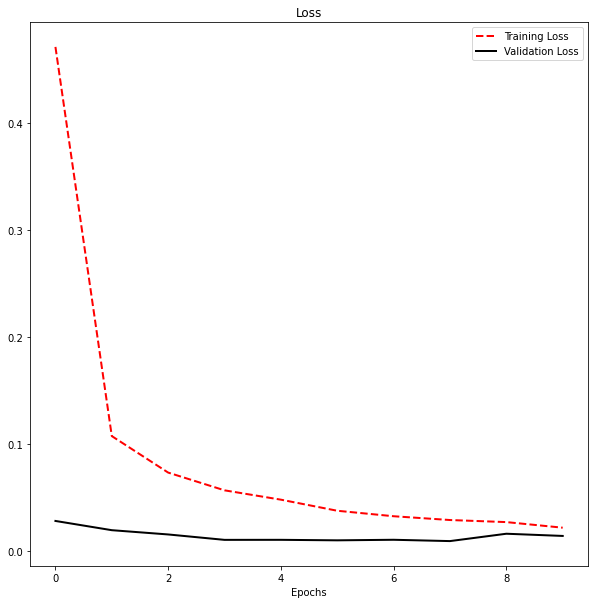

In [6]:
plt.figure(figsize=(10,10))
plt.plot(hist[0], 'r--',lw=2, label='Training Loss')
plt.plot(hist[2], 'k',lw=2, label='Validation Loss')
plt.legend(loc=1)
plt.title('Loss')
plt.xlabel('Epochs')
plt.show()

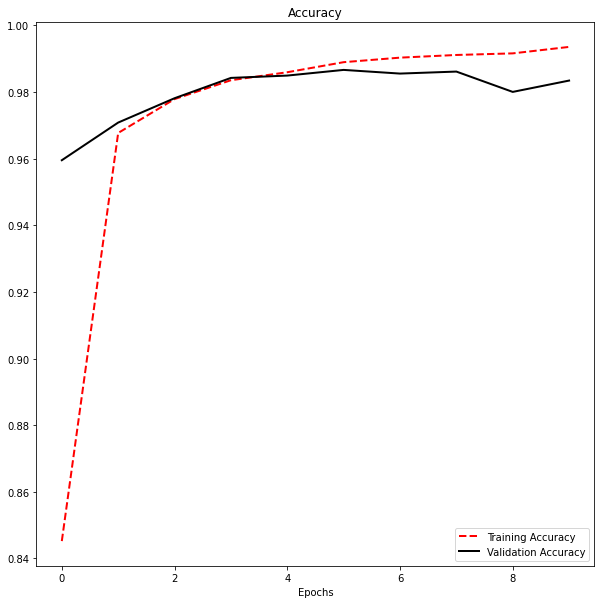

In [7]:
plt.figure(figsize=(10,10))
plt.plot(hist[1], 'r--',lw=2, label='Training Accuracy')
plt.plot(hist[3], 'k',lw=2, label='Validation Accuracy')
plt.legend(loc=4)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.show()

## Test Accuracy + Confusion Matrix

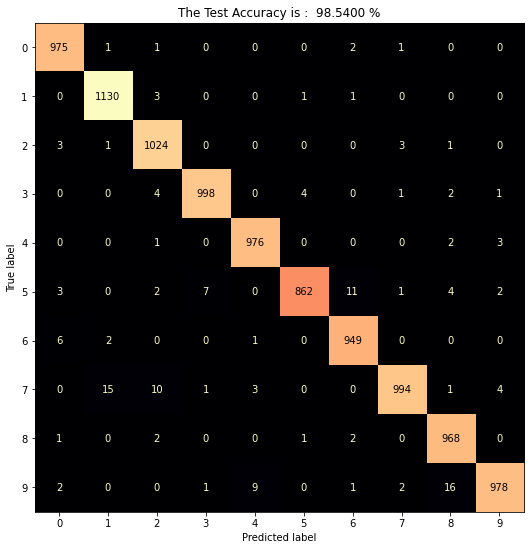

In [8]:
model.to('cpu')
pred = torch.argmax(model((mnist_test_dataset.data.unsqueeze(1)/255)), dim=1)

correct = (pred == mnist_test_dataset.targets).float()
test_acc = correct.sum()/len(mnist_test_dataset.targets)
conf_matrix_1 = confusion_matrix(mnist_test_dataset.targets, pred)
fig, ax = plt.subplots(figsize=(9, 9))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_1,)
disp.plot(ax=ax, cmap=plt.cm.magma, colorbar=False)
plt.title(f'The Test Accuracy is : {test_acc*100 : .4f} %')
plt.savefig('conf_MNIST_cnn_no_dropout.jpg', bbox_inches='tight')
plt.show()